# Heart Failure Classification
#### Reid Souchereau
#### 12/9/2020

This classification project will use the [Heart Failure Dataset](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data?select=heart_failure_clinical_records_dataset.csv) from Kaggle, courtesy of user Larxel. This will have various independent variables regarding the patient's individual factors and related chemical concentrations/gradients.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("datasets\heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
print("Column Names:\n"+"-"*20)
for name in df.columns:
    print(name)

Column Names:
--------------------
age
anaemia
creatinine_phosphokinase
diabetes
ejection_fraction
high_blood_pressure
platelets
serum_creatinine
serum_sodium
sex
smoking
time
DEATH_EVENT


We have our dataframe now. A couple columns are binary, including:
- anaemia
- diabetes
- high_blood_pressure
- sex
- smoking
- DEATH_EVENT - outcome variable

So lets do a quick EDA to find anything interesting.

## EDA

In [4]:
# Find any null values
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [5]:
# Separate out binary columns
binary_cols = ["anaemia","diabetes","high_blood_pressure","sex","smoking"]
cont_cols = []

for col in df.columns:
    if col not in binary_cols:
        cont_cols.append(col)
cont_cols.remove("DEATH_EVENT")

print(binary_cols,"\n",cont_cols)

['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking'] 
 ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


### Scatter Matrix

First we will do a scatter matrix to separate out our data and see any possible clustering that could be capitalized with an SVM.

C:\Users\Reid\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


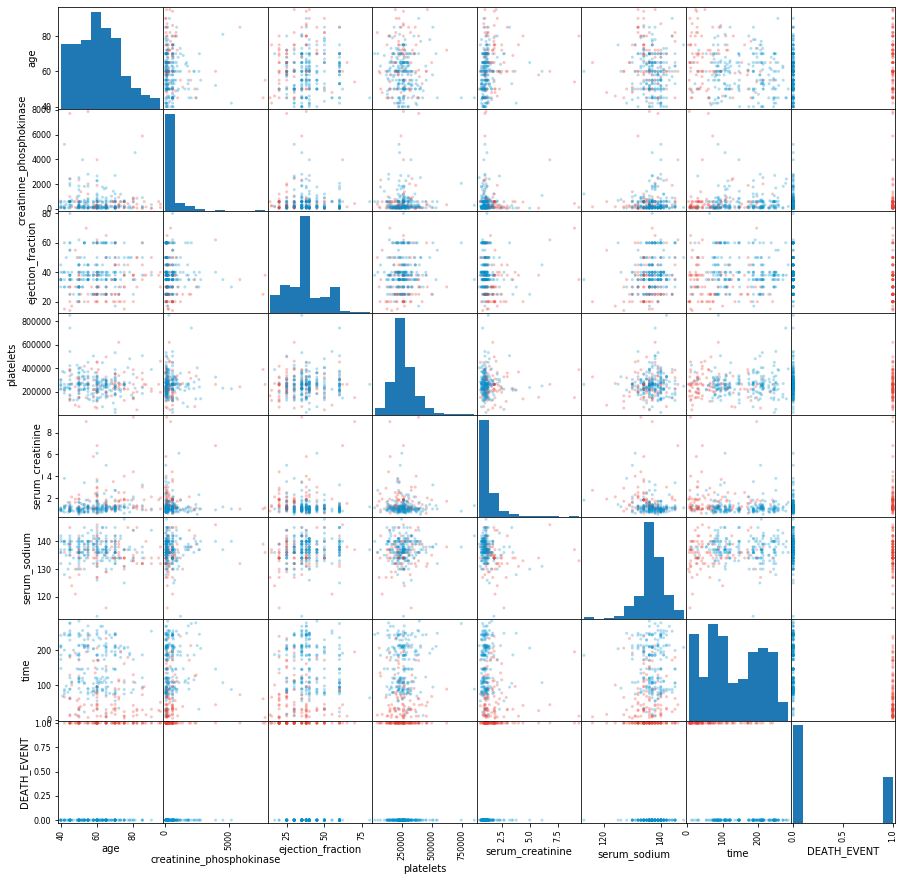

In [6]:
from pandas.plotting import scatter_matrix
color_wheel = {1: "#0392cf",  
               2: "#ee4035"}
colors = df["DEATH_EVENT"].map(lambda x: color_wheel.get(x+1))
df_cont = df[cont_cols]
df_cont["DEATH_EVENT"] = df["DEATH_EVENT"]
ax = scatter_matrix(df_cont, color=colors, alpha=0.3, figsize=(15, 15), diagonal='hist')

We could attempt a simple logistic regression with some of these continuous variables, as well as some variables seem to have some strong spatial definitions for an SVM.

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

## Model Selection

Let's start with a simple linear SVM for our continuous data.

### Pipeline

In [8]:
# Pipeline
continuous_pipeline = Pipeline([
    ("Scaler", StandardScaler()),
    ("Normalizer", MinMaxScaler())
])

svm_ct = ColumnTransformer ([
    ("Continuous Data Pipeline", continuous_pipeline, cont_cols)], 
    remainder= "drop")

Ok so we set up a simple pipeline to scale and normalize our data for the SVM. Lastly, let's just re-import a dataframe of the data to test the pipline.

In [9]:
data = pd.read_csv("datasets\heart_failure_clinical_records_dataset.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [10]:
y = data.pop("DEATH_EVENT")
x = data.copy()
x = x[cont_cols]
print(x.head(),"\n",y.head())

    age  creatinine_phosphokinase  ejection_fraction  platelets  \
0  75.0                       582                 20  265000.00   
1  55.0                      7861                 38  263358.03   
2  65.0                       146                 20  162000.00   
3  50.0                       111                 20  210000.00   
4  65.0                       160                 20  327000.00   

   serum_creatinine  serum_sodium  time  
0               1.9           130     4  
1               1.1           136     6  
2               1.3           129     7  
3               1.9           137     7  
4               2.7           116     8   
 0    1
1    1
2    1
3    1
4    1
Name: DEATH_EVENT, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Transform X data
X_train_trans = svm_ct.fit_transform(X_train)
X_test_trans = svm_ct.fit_transform(X_test)

# Convert y to array
y_train_trans = y_train.values
y_test_trans = y_test.values

### Linear SVC

In [12]:
# Build LinearSVC
svm = LinearSVC(C=1, loss="hinge")

In [13]:
svm.fit(X_train_trans,y_train_trans)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [14]:
svm_predictions = svm.predict(X_test_trans)
svm_pred_bool = (svm_predictions == y_test_trans)
svm_pred_bool.sum()/y_test_trans.shape[0]

0.8

Let's try a cross validation to get a better depiction of the accuracy.

In [15]:
from sklearn.model_selection import cross_val_score
svm_cross_val_score = cross_val_score(svm, svm_ct.fit_transform(x), y=y.values)
svm_cross_val_score.sum()/5

0.7789265536723164

How about adding polynomial features?

### Polynomial SVC

In [16]:
from sklearn.svm import SVC

# Build SVC
svc = SVC(kernel="poly", degree=3, coef0=1, C=5)
svc.fit(X_train_trans,y_train)

# Make Predictions on test data
svc_predictions = svc.predict(X_test)
svc_predictions_bool = svc_predictions == y_test
svc_predictions_bool.sum()/y_test.shape[0]

0.4

In [17]:
# Cross validation
svc_cross_val_score = cross_val_score(svc, svm_ct.fit_transform(x), y=y.values)
svc_cross_val_score.sum()/5

0.7489830508474576

Interestingly enough, our higher order polynomials did not improve our model much. As a last ditch effort for an SVM, we can try to use a grid search to optimize parameters.

### Grid Search for SVC

In [18]:
from sklearn.model_selection import GridSearchCV

# {'C': [1,10,100] , 'kernel':['linear']},
parameters = [{'C': [0.001,0.01, 0.1, 1,10,100], 'kernel':['rbf'], 'gamma':[0.01, 0.05,0.1,0.5,1]}]

svc_grid = GridSearchCV(SVC(), parameters, cv=5, scoring="accuracy")
svc_grid.fit(svm_ct.fit_transform(x),y)

print("The best parameters are %s with a score of %0.2f" % (svc_grid.best_params_, svc_grid.best_score_))
print("Mean fit times: {0}".format(svc_grid.cv_results_['mean_fit_time']))

The best parameters are {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'} with a score of 0.78
Mean fit times: [0.00120029 0.00100021 0.00120049 0.00100017 0.00100017 0.00099988
 0.00100055 0.00100002 0.00120044 0.00100026 0.00120025 0.00100007
 0.00100036 0.00100012 0.00100026 0.00100031 0.00099993 0.00100031
 0.0010005  0.00100007 0.0010004  0.00100026 0.00100012 0.00100031
 0.00100017 0.00100031 0.00120029 0.00100055 0.00180049 0.00220046]


So this is not ideal. One last attempt, lets try grid search with a linear SVC. If this is not optimal, we will try to use logistic regression.

### Grid Search Linear SVC

In [19]:
parameters = [{'penalty':['l1','l2'],'dual':[False], 'C':[1,2,5,10],'fit_intercept':[True,False]}]

linearsvc_grid = GridSearchCV(LinearSVC(), param_grid = parameters, scoring="accuracy")
linearsvc_grid.fit(svm_ct.fit_transform(x),y)

print("The best parameters are %s with a score of %0.2f" % (linearsvc_grid.best_params_, linearsvc_grid.best_score_))
print("Mean fit times: {0}".format(linearsvc_grid.cv_results_['mean_fit_time']))

The best parameters are {'C': 1, 'dual': False, 'fit_intercept': True, 'penalty': 'l1'} with a score of 0.80
Mean fit times: [0.00150485 0.00060024 0.00040021 0.00020008 0.00120006 0.00020018
 0.00019999 0.00080028 0.00160074 0.00059991 0.00060043 0.00020008
 0.00200047 0.0006     0.00100026 0.00040002]


So our **LinearSVC** has the best accuracy of all of our current SVM models. Now lets try some logistic regression.

### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

# Build Logistic Regression Model
logreg = LogisticRegression()
logreg.fit(X_train_trans,y_train_trans)

# Predictions on test data
logreg_predictions = logreg.predict(X_test_trans)
logreg_predictions_bool = logreg_predictions == y_test
logreg_predictions_bool.sum()/y_test.shape[0]

0.8333333333333334

83% accuracy is pretty solid. Let's try a cross-validation, then look at some model validation.

In [21]:
logreg_predictions_cv = cross_val_score(logreg,svm_ct.fit_transform(x),y,cv=5)
logreg_predictions_cv.sum()/5

0.785593220338983

The last model we will attempt will be a Gradient Boosting Classifier.

### GBC

In [22]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
gbc = GBC(n_estimators=10, random_state=0)
gbc.fit(X_train_trans,y_train_trans)
gbc.score(X_test_trans,y_test_trans)

0.7

In [23]:
# Test with standard x data - no transform
gbc.fit(x,y)
gbc.score(X_test,y_test)

0.8

In [24]:
# Cross validation
gbc_cv_score = cross_val_score(gbc,x,y,cv=10)
gbc_cv_score.sum()/10

0.7389655172413793

### GBC Grid Search

In [25]:
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 5),
    "min_samples_leaf": np.linspace(0.1, 0.5, 5),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "n_estimators":[10]
    }

In [26]:
gbc_grid = GridSearchCV(GBC(), parameters, cv=10)
gbc_grid.fit(x,y)

print("The best parameters are %s with a score of %0.2f" % (gbc_grid.best_params_, gbc_grid.best_score_))
print("Mean fit times: {0}".format(gbc_grid.cv_results_['mean_fit_time']))

The best parameters are {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.2, 'min_samples_split': 0.5, 'n_estimators': 10, 'subsample': 0.8} with a score of 0.85
Mean fit times: [0.0047272  0.00480118 0.00473635 ... 0.00400083 0.00400059 0.00360084]


So with the GBC grid search, we got our accuracy score up to 84%, which is better than our other models.

## ROC Curve

In [27]:
from sklearn.metrics import plot_roc_curve

In [28]:
# Assign linear svc from grid to a new model object
linearsvc_final = linearsvc_grid.best_estimator_
linearsvc_final.fit(svm_ct.fit_transform(x),y)

LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
          verbose=0)

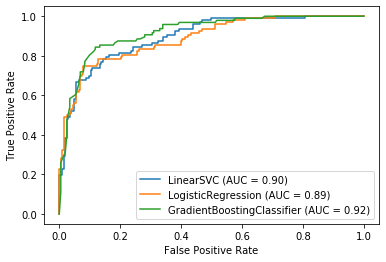

In [43]:
ax = plt.gca()
linearsvc_disp = plot_roc_curve(linearsvc_final, svm_ct.fit_transform(x), y, ax=ax)
log_disp = plot_roc_curve(logreg, svm_ct.fit_transform(x), y, ax=ax)
gbc_disp = plot_roc_curve(gbc_grid.best_estimator_, x, y, ax=ax)
plt.show()

As we can see from our ROC curve, our **Gradient Boosting Classifier** got the most area under the curve, telling us that it is our best model from our model selection.